In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats

In [2]:
%%time

num_snapshots = 10#1000
n_p = 15
n_b = 200
n_b_calc = n_b
l_0 = .1 #length_kuhn = (10 l_k) = (20 l_p) = (200 l_0)
l_p = 1
kappa = l_p/l_0
all_snaps = np.zeros(num_snapshots, dtype=object)
for snap in range(num_snapshots):
    output = np.zeros([n_p*n_b, 3])

    for poly in range(n_p):
        #first bead
        r1 = np.array([0, 0, 0])
        output[poly*n_b] = r1
        
        phi = 2*np.pi*random.uniform(0, 1)
        theta = np.arccos(random.uniform(-1, 1))
        u_1 = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
        r2 = u_1 * l_0
        output[poly*n_b + 1] = r2
        
#         print("r2: phi = ", phi)
#         print("r2: theta = ", theta)
#         print("r2: u_1 = ", u_1)
        
        for bead in range(n_b-2):
            r = random.uniform(0, 1)
            rho = (1/kappa)*np.log(np.exp(-kappa)+r*(np.exp(kappa)-np.exp(-kappa)))
            theta = np.arccos(rho) #5/16 added np.pi minus -> wrong
            phi = 2*np.pi*random.uniform(0, 1)
            
#             print("r" + str(bead+3) + ": theta = ", theta )
#             print("r" + str(bead+3) + ": phi = ", phi )

            #define z' as previous bond vector
    
            z_prime = output[poly*n_b + bead + 1] - output[poly*n_b + bead] #bond vector preceeding
            z_prime = z_prime / np.linalg.norm(z_prime) #just the u (r/l0)
                
            x_prime = np.random.randn(3)  # take a random vector 
            x_prime -= np.dot(x_prime, z_prime) * z_prime      # make it orthogonal to z_prime
            x_prime /= np.linalg.norm(x_prime)

            y_prime = np.cross(z_prime, x_prime)

            #calculate new r_prime in x'y'z' axes

            r_prime = l_0 * np.array([np.sin(theta)*np.cos(phi), 0+np.sin(theta)*np.sin(phi), np.cos(theta)]) # l_0 * u_bead where (phi = random)
            #even though should have random axes, ensuring randomness to phi by including additional rotation about z'.
#             print("r' before changing axes: ", r_prime)
            
            #convert r_prime from x'y'z' to xyz

            axes_1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
            origin_1 = np.array([0, 0, 0])

            axes_2 = np.array([x_prime, y_prime, z_prime]).T
            origin_2 = output[poly*n_b + bead + 1]
            
            # o1 + m1.p1 = o2 + m2.p2
            r_bead = np.dot(np.transpose(axes_1), (origin_2 - origin_1 + np.dot(axes_2, r_prime)))
            
#             print("r" + str(bead+3) + ": prime axis = ", axes_2)
#             print("r" + str(bead+3) + ": prime origin = ", origin_2)

            output[poly*n_b + bead + 2] = r_bead
            
            #troubleshooting
#             bond_vect = (output[poly*n_b + bead + 2] - output[poly*n_b + bead + 1])
#             z_ax = z_prime
            
#             ang_btw = np.arccos(bond_vect.dot(z_ax)/ (np.linalg.norm(z_ax)*np.linalg.norm(bond_vect)))
#             print("angle between vects: ", ang_btw)
#             print(ang_btw+theta)
    all_snaps[snap] = output

Wall time: 5.15 s


In [3]:
%%time
#Vectorize attempt- grow all chains simultaneously. 10x faster

num_snapshots = 10#00
n_p = 15
n_b = 200
n_b_calc = n_b
l_0 = .1 #length_kuhn = (10 l_k) = (20 l_p) = (200 l_0)
l_p = 1
kappa = l_p/l_0
all_snaps_vect = np.zeros(num_snapshots, dtype=object)

axes_1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
origin_1 = np.array([0, 0, 0])

for snap in range(num_snapshots):
    output = np.zeros([n_p*n_b, 3])
    r1 = np.array([0, 0, 0])
    output[::n_b] = r1
    
    phi = 2*np.pi*np.random.rand(n_p)
    theta = np.arccos(stats.uniform(-1, 2).rvs(n_p))
    u2 = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]).T
    r2 = u2 * l_0
    output[1::n_b] = r2
    
    for bead in range(n_b-2):
        r = np.random.rand(n_p)
        rho = (1/kappa)*np.log(np.exp(-kappa)+r*(np.exp(kappa)-np.exp(-kappa)))
        theta = np.arccos(rho)
        phi = 2*np.pi*np.random.rand(n_p)
        
        z_prime = output[bead+1::n_b] - output[bead::n_b] #previous bond vector
        z_prime = z_prime/np.linalg.norm(z_prime, axis = -1)[:, np.newaxis] #normalize each row in matrix - could just /l0
        
        x_prime = np.random.randn(n_p, 3)
        x_prime -= np.sum(x_prime*z_prime, axis=1)[:, None] * z_prime #np.sum is row-wise dot product
        x_prime = x_prime/np.linalg.norm(x_prime, axis = -1)[:, np.newaxis]
        
        y_prime = np.cross(z_prime, x_prime)
        
        r_prime = (l_0 * np.array([np.sin(theta)*np.cos(phi), 0+np.sin(theta)*np.sin(phi), np.cos(theta)])).T # u_bead where (phi = 0)
        #even though x and y axes are random, ensuring randomness by including phi rotation.
        
        #convert r_prime from x'y'z' to xyz 
        
        origin_2 = output[bead+1::n_b]
        axes_2 = np.stack((x_prime, y_prime, z_prime), axis=-1) #axis = -1 transposes
        r_bead = origin_2 + np.einsum('ipq,iq->ip',axes_2,r_prime) #element-wise dot product
        output[bead+2::n_b] = r_bead
    all_snaps_vect[snap] = output
        

Wall time: 439 ms


In [4]:
import sys
sys.path.insert(1, '../wlcstat/')

In [5]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import wlcstat.wlcave as wlcave
import wlcstat.wlcgreen as wlcgreen
import wlcstat.wlcstruc as wlcstruc
import wlcstat.poly_dyn as poly_dyn
import wlcstat.wlc_lcpoly as wlc_lcpoly
import wlcstat.poly_confine as poly_confine
import wlcstat.active_brown as active_brown
import wlcstat.util.wlc_vertex as vertex
import importlib

In [6]:
import importlib
importlib.reload(wlcave)
importlib.reload(wlcgreen)
importlib.reload(wlcstruc)
importlib.reload(poly_dyn)
importlib.reload(poly_confine)
importlib.reload(wlc_lcpoly)
importlib.reload(active_brown)

<module 'wlcstat.active_brown' from 'C:\\Users\\Thomas\\Desktop\\structure_factor\\structure_factor\\wlcstat\\active_brown.py'>

In [7]:
n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10
i_snap_0 = 9000
i_snap_f = 10000

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

s2_sim = np.zeros(nk)

for i_snap in range(i_snap_0, i_snap_f + 1):
    u_snap = np.loadtxt('sim_data/u' + str(i_snap))
    r_snap = np.loadtxt('sim_data/r' + str(i_snap))
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :]
        
        #why can you separate by x, y, z?
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,0]) / 2)        
        s2_sim += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,1]) / 2)        
        s2_sim += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,2]) / 2)        
        s2_sim += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)

In [8]:
i_snap_f = num_snapshots-1
i_snap_0 = 0

s2_sim_cga = np.zeros(nk)
for i_snap in range(num_snapshots):
    r_snap = all_snaps[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :]

        #why can you separate by x, y, z?
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,0]) / 2)        
        s2_sim_cga += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,1]) / 2)        
        s2_sim_cga += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,2]) / 2)        
        s2_sim_cga += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)

In [9]:
i_snap_f = num_snapshots-1
i_snap_0 = 0

s2_sim_cga_vect = np.zeros(nk)
for i_snap in range(num_snapshots):
    r_snap = all_snaps_vect[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :]

        #why can you separate by x, y, z?
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,0]) / 2)        
        s2_sim_cga_vect += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,1]) / 2)        
        s2_sim_cga_vect += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,2]) / 2)        
        s2_sim_cga_vect += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)

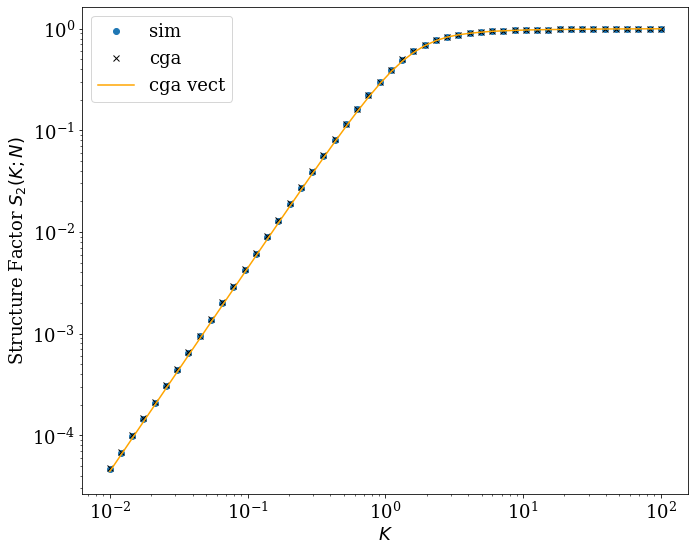

In [12]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
    
plt.plot(k_vec, 1-s2_sim,'o', label = "sim")
plt.plot(k_vec, 1-s2_sim_cga, "x", color = "black", label = "cga")
plt.plot(k_vec, 1-s2_sim_cga_vect, color = "orange", label = "cga vect")
#plt.plot(k_vec, 1-s2_th,'-')    
#plt.plot(k_vec, 1-s2_asymp,'--')    

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
#plt.xlim((1e-2, 1e2))
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# %%time
# #Vectorize attempt- grow all chians simultaneously

# num_snapshots = 10#00
# n_p = 15
# n_b = 200
# n_b_calc = n_b
# l_0 = .1 #length_kuhn = (10 l_k) = (20 l_p) = (200 l_0)
# l_p = 1
# kappa = l_p/l_0
# all_snaps_vect = np.zeros(num_snapshots, dtype=object)
# for snap in range(num_snapshots):
#     output = np.zeros([n_p*n_b, 3])
#     r1 = np.array([0, 0, 0])
#     output[::n_b] = r1
    
#     phi = 2*np.pi*np.random.rand(n_p)
#     theta = np.arccos(stats.uniform(-1, 2).rvs(n_p))
#     u2 = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]).T
#     r2 = u2 * l_0
#     output[1::n_b] = r2
    
#     for bead in range(n_b-2):
#         r = np.random.rand(n_p)
#         rho = (1/kappa)*np.log(np.exp(-kappa)+r*(np.exp(kappa)-np.exp(-kappa)))
#         theta = np.arccos(rho)
#         phi = 2*np.pi*np.random.rand(n_p)
        
#         z_prime = output[bead+1::n_b] - output[bead::n_b] #previous bond vector
#         z_prime = z_prime/np.linalg.norm(z_prime, axis = -1)[:, np.newaxis] #normalize each row in matrix - could just /l0
        
#         x_prime = np.random.randn(n_p, 3)
#         x_prime -= np.sum(x_prime*z_prime, axis=1)[:, None] * z_prime #np.sum is row-wise dot product
#         x_prime = x_prime/np.linalg.norm(x_prime, axis = -1)[:, np.newaxis]
        
#         y_prime = np.cross(z_prime, x_prime)
        
#         r_prime = (l_0 * np.array([np.sin(theta)*np.cos(phi), 0+np.sin(theta)*np.sin(phi), np.cos(theta)])).T # u_bead where (phi = 0)
#         #even though x and y axes are random, ensuring randomness by including phi rotation.
        
#         #convert r_prime from x'y'z' to xyz
#         #have n_p coord axes and n_p r_primes 
        
#         axes_1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
#         origin_1 = np.array([0, 0, 0])
#         for poly in range(n_p):
#             axes_2 = np.array([x_prime[poly], y_prime[poly], z_prime[poly]]).T
#             origin_2 = output[poly*n_b + bead + 1]
#             r_bead = np.dot(np.transpose(axes_1), (origin_2 - origin_1 + np.dot(axes_2, r_prime[poly]))) #too complicated to vectorize
#             output[poly*n_b + bead + 2] = r_bead
            
#     all_snaps_vect[snap] = output
#         #output[bead+2::n_b] = r_bead
        
# #         x_prime = np.random.randn(3)  # take a random vector (phi = random angle)
# #         x_prime -= np.dot(x_prime, z_prime) * z_prime      # make it orthogonal to z_prime
# #         x_prime /= np.linalg.norm(x_prime)

# #         y_prime = np.cross(z_prime, x_prime)